## There are two crucial stages for this bit. 

#### Firstly we need to be able to get the letters from the identity into their own boxes. Here you see an example, but its not so robust right now. 
#### Then we take 2 models trained, one trained on the relevant letters and one trained on the numbers (there are good publically available datasets) and predict. 

In [45]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys

from helper import *
import csv  
from io import BytesIO
from IPython import display

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

import torch
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon


In [1093]:
incorrectos = np.load('incorrect_files.npy')

file= incorrectos[7]


image = RetreiveImage(file, verbose=True)


img_byte_array = CroppedImage(image, verbose=True)

client = vision.ImageAnnotatorClient()
content = img_byte_array.getvalue()
image = vision.Image(content=content)

response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})


Image has been read from google bucket.

Image has been cropped.


In [1094]:
RetreiveImage(file, verbose=True)



Image has been read from google bucket.


In [1095]:
def extract_vertices(bounding_box):
    vertices = []
    for vertex in bounding_box.vertices:
        vertices.append((vertex.x, vertex.y))
    return vertices

In [1096]:
bounding_box = []
character = []

for page in response.full_text_annotation.pages:
    for block in page.blocks:

        for paragraph in block.paragraphs:
            
            for word in paragraph.words:
                for symbol in word.symbols:
                    vertices = extract_vertices(symbol.bounding_box)

                    bounding_box.append(vertices)
                    character.append(symbol.text)


bounding_box = np.array(bounding_box)

print(character)

['F', 'L', 'L', 'Q', 'W', '7', 'V', '0', '1', '/', '2', '7', '/', '1', '3']


C:\Users\howards\AppData\Local\Temp\ipykernel_20272\1945618019.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)


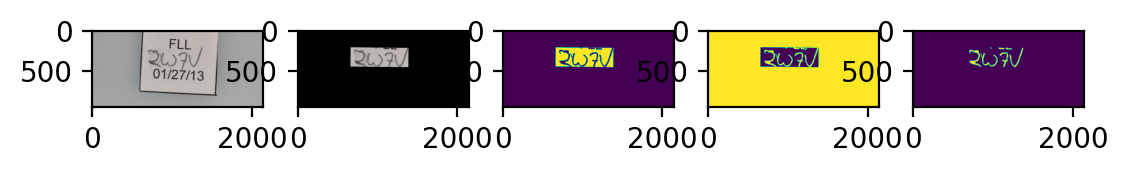

In [1112]:
para_box = np.array(extract_vertices(block.paragraphs[1].bounding_box))

decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)
frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR)


pad = 20


#firstly find the box around the identity, and also calculate the approx angle of rotation of that box. 
adapted_para_box = para_box.copy()

x = np.argsort(para_box[:,0])
y = np.argsort(para_box[:,1])

adapted_para_box[x[:2],0] = para_box[x[:2],0] - pad
adapted_para_box[x[2:],0] = para_box[x[2:],0] + pad

adapted_para_box[y[:2],1] = para_box[y[:2],1] - pad
adapted_para_box[y[2:],1] = para_box[y[2:],1] + pad

rel_area = polygon(adapted_para_box[:,1], adapted_para_box[:,0]) 
mask1 = np.zeros(frame.shape[:2], dtype=np.uint8)
mask1[rel_area] = 1


idx = para_box[:,1].argsort()[:2]
dx = para_box[idx[1],0] - para_box[idx[0],0]
dy = para_box[idx[1],1] - para_box[idx[0],1]

angle = np.arctan2(dy,dx)



fig,ax = plt.subplots(1,5,dpi=200)
ax[0].imshow(frame)
frame = frame*mask1[...,None] #mask the image

ax[1].imshow(frame)

frame = np.mean(frame, axis=2)

thresh = 140

frame[frame < thresh] = 0
frame[frame !=0] = 1 #greyscake the image and binarize


ax[2].imshow(frame)

frame = rotate(frame, -angle, resize=False, ) #rotate the image
frame = (1-frame) #invert and threshold.
frame[frame < 0.5] = 0
frame[frame !=0] = 1

ax[3].imshow(frame)

x,y = np.where(frame==0)

coords = np.array([[x[y.argmin()], y.min()],  [x.min(), y[x.argmin()]], [x[y.argmax()], y.max()],[x.max(), y[x.argmax()]]])

rel_area = polygon(coords[:,0], coords[:,1])
mask = np.zeros(frame.shape[:2], dtype=np.uint8)
mask[rel_area] = 1

frame*= mask #set everywhere outside the letters to zero, just leaving the letters

ax[4].imshow(frame)

kernel = np.ones((5, 5), np.uint8)
frame = cv2.dilate(frame, kernel, iterations=1) #finally we can dilate, in order to merge letters that are in two parts?

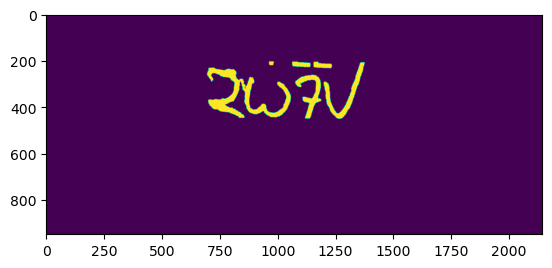

In [1113]:
%matplotlib inline
plt.imshow(frame)

Idea:

Dilate to join up parts of letters that may be separated. Run CCwS. Then based on the labels, if the width is too great we assume two letters are joined, erode, and run CCwS on that box again. Always delete labels that have too small a height.  

In [1104]:
def FindConnectedComponents(image, thresholds=None):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(image), connectivity=8)
    store_characters = []
    store_x = []
    store_multi = []

    for i in range(1,len(np.unique(labels))): #the first one is always background
        if (stats[i,4] > 1000): #if area of region is big (no noise)

            char_label = np.zeros_like(labels)
            char_label[labels != i] = 0
            char_label[labels == i] = 1

            x,y,w,h = stats[i,:4]

            if w<20: #crap
                continue
            
            if h<70: #crap 
                continue


            if w<200: #one letter

                store_x.append(x)

                character = char_label[y:y+h,x:x+w]
                store_characters.append(character)


            else: #probably two letters...

                store_x.append(x)

                character = char_label[y:y+h,x:x+w]
                store_characters.append(character)
                store_multi.append(x)



    store_characters = np.array(store_characters)
    store_characters = store_characters[np.argsort(store_x)]
    store_x = np.sort(store_x)

    store_multi = np.array([np.where(store_x==i)[0][0] for i in store_multi])


    return store_characters, store_x, store_multi



In [1114]:

store_characters, store_x, store_multi = FindConnectedComponents(frame)

C:\Users\howards\AppData\Local\Temp\ipykernel_20272\2063520765.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  store_characters = np.array(store_characters)


In [1115]:
store_multi

array([0], dtype=int64)

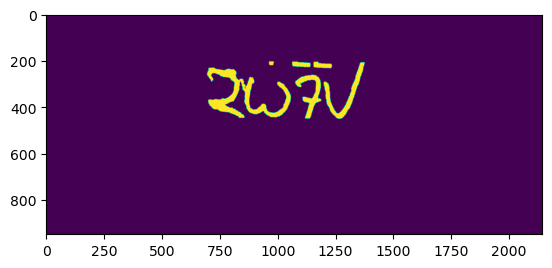

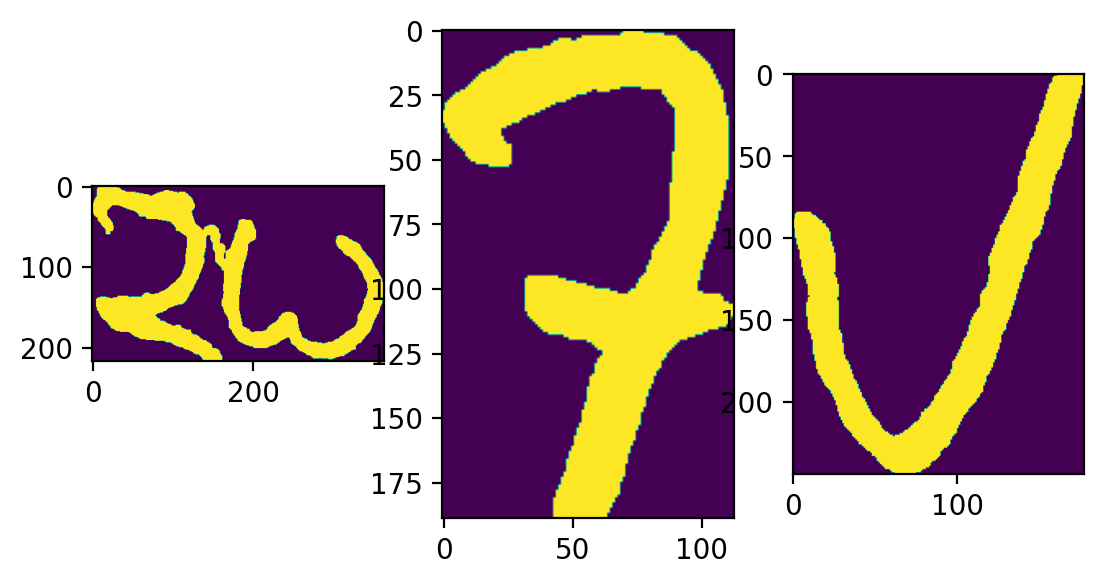

In [1116]:
plt.imshow(frame)

fig,ax = plt.subplots(1,len(store_characters),dpi=200)
for i in range(len(store_characters)):
    ax[i].imshow(store_characters[i])

deal with the multiple letters...

In [1108]:
master_list = []    
new_chars = []


for i in store_multi:

    eg = store_characters[i]

    erosion = 3
    
    store_characters_mini, store_x_mini, store_multi_mini = FindConnectedComponents(eg)

    while len(store_characters_mini) < 2: 

        kernel = np.ones((erosion, erosion), np.uint8)
        eg = cv2.erode(np.uint8(eg), kernel, iterations=1)

        store_characters_mini, store_x_mini, store_multi_mini = FindConnectedComponents(eg)

        erosion+=1

    new_chars.append(store_characters_mini)

    print(erosion)
    




6


C:\Users\howards\AppData\Local\Temp\ipykernel_20272\2063520765.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  store_characters = np.array(store_characters)


In [1110]:
master_list = []

n = 0

for i in range(len(store_characters)):
    if i in store_multi:
        for j in new_chars[n]:
            master_list.append(j)
        n+=1
    else:
        master_list.append(store_characters[i])


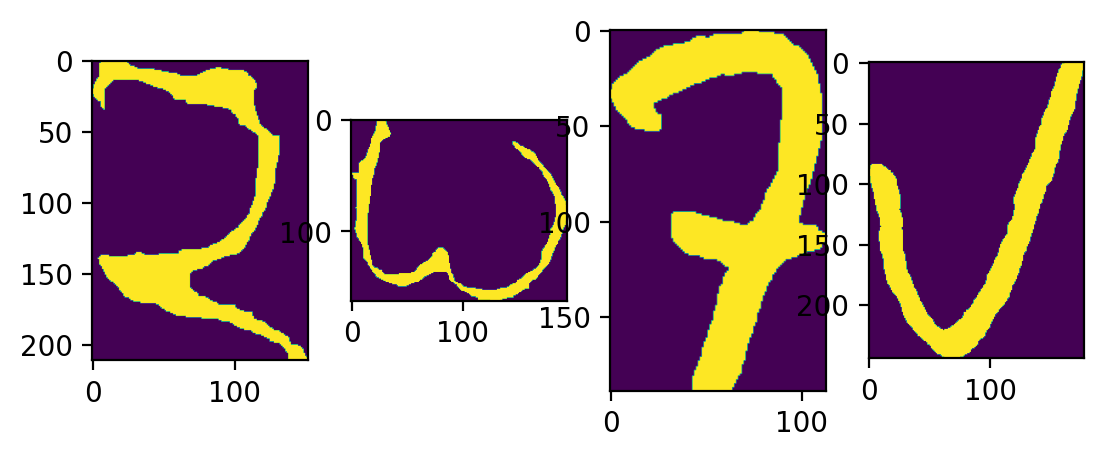

In [1111]:
fig,ax = plt.subplots(1,len(master_list),dpi=200)
for n,i in enumerate(master_list):
    ax[n].imshow(i)